# Merge sort


This example illustrates the use of `DataFlowTasks` to implement a parallel
[merge sort](https://en.wikipedia.org/wiki/Merge_sort) algorithm.

## Sequential version

We'll use a "bottom-up" implementation of the merge sort algorithm. To explain
how it works, let's consider a small vector of 32 elements:

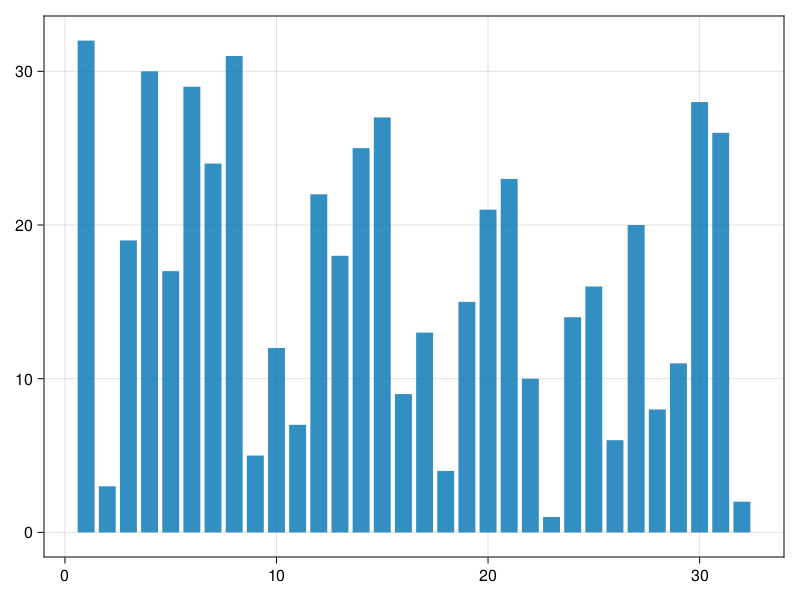

In [1]:
using Random, CairoMakie
include("helper.jl") # plotting utilities
Random.seed!(42)

v = randperm(32)
barplot(v)

We decompose it into 4 blocks of 8 elements, which we sort individually:

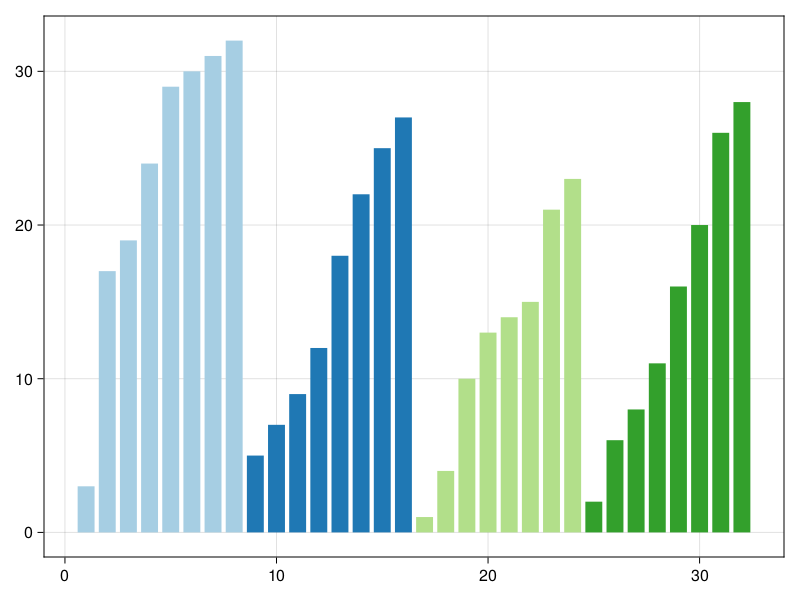

In [2]:
sort!(view(v, 1:8))
sort!(view(v, 9:16))
sort!(view(v, 17:24))
sort!(view(v, 25:32))
barplot(v; color=ceil.(Int, eachindex(v)./8), colormap=:Paired_4, colorrange=(1,4))

Now we can merge the first two 8-element blocks into a sorted 16-element
block. And do the same for the 3rd and 4th 8-element blocks. We'll need an
auxilliary array `w` to store the results:

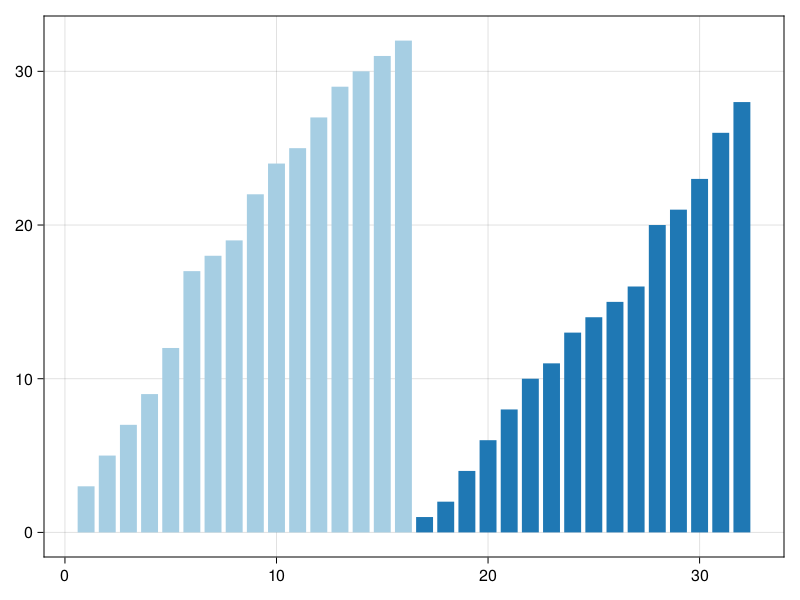

In [3]:
function merge!(dest, left, right)
    # pre-condition:
    #   `left`  is sorted
    #   `right` is sorted
    #   length(left) + length(right) == length(dest)
    # post-condition:
    #   `dest` contains all elements from `left` and `right`
    #   `dest` is sorted

    (i, j) = (1, 1)
    (I, J) = (length(left), length(right))
    @assert I + J == length(dest)
    @inbounds for k in eachindex(dest)
        if i <= I && (j > J || left[i] < right[j])
            dest[k] = left[i]; i += 1
        else
            dest[k] = right[j]; j+=1
        end
    end
end

w = similar(v)
@views merge!(w[1:16],  v[1:8],   v[9:16])
@views merge!(w[17:32], v[17:24], v[25:32])
barplot(w; color=ceil.(Int, eachindex(v)./16), colormap=:Paired_4, colorrange=(1,4))

Now `w` is sorted in two blocks, which we can merge to get the entire sorted
array. Instead of using a new buffer to store the results, let's re-use the
original array `v`:

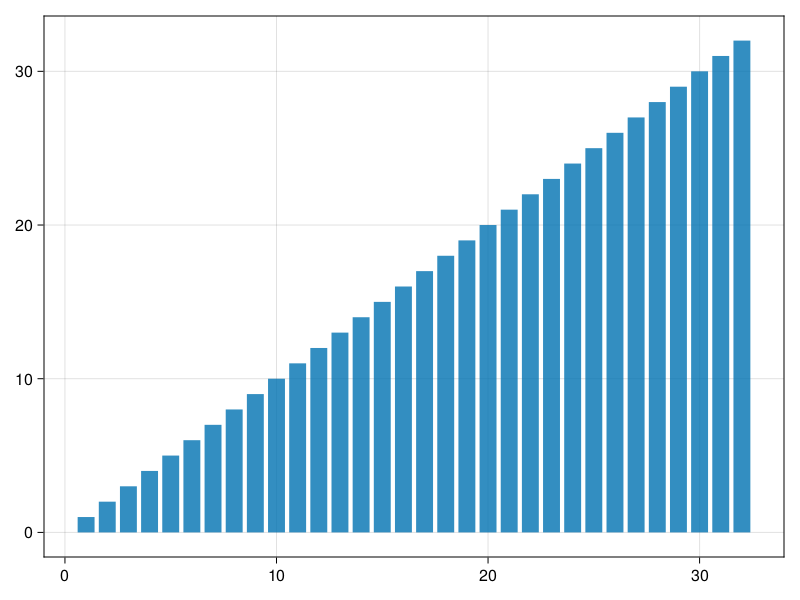

In [4]:
@views merge!(v, w[1:16], w[17:32])
barplot(v)

The following sequential implementation automates these steps.

First, the vector is decomposed in blocks of size `bs` (`64` by default). Each
block is sorted using an insertion sort (which works in-place without
allocating anything, and is relatively fast for small vectors).

Then, sorted blocks are grouped in pairs which are merged into the buffer. If
the number of blocks is odd, the last block is copied directly to the
destination buffer.

The auxiliary buffer is now composed of sorted blocks twice as large as the
original blocks, so we can iterate the algorithm with a doubled block size,
this time putting the results back to the original vector.

Depending on the parity of the number of iterations, the final result ends up
being stored either in the original vector (which is what we want) or in the
auxiliary buffer (in which case we copy it back to the original vector). The
semantics of `mergesort!` is thus that of an in-place sort: after the call,
`v` should be sorted.

In [5]:
function mergesort!(v, buf=similar(v), bs=64)
    N = length(v)

    for i₀ in 1:bs:N
        i₁ = min(i₀+bs-1, N)
        sort!(view(v, i₀:i₁), alg=InsertionSort)
    end

    (from, to) = (v, buf)

    while bs < length(v)
        i₀ = 1
        while i₀ < N
            i₁ = i₀+bs; i₁>N && break
            i₂ = min(i₀+2bs-1, N)
            @views merge!(to[i₀:i₂], from[i₀:i₁-1], from[i₁:i₂])

            i₀ = i₂+1
        end
        if i₀ <= N
            @inbounds @views to[i₀:N] .= from[i₀:N]
        end

        bs *= 2
        (from, to) = (to, from)
    end

    v === from || copy!(v, from)
    v
end

N = 100_000
v = rand(N)
buf = similar(v)

@assert issorted(mergesort!(copy(v), buf))

## Parallel version

Parallelizing with DataFlowTasks involves splitting the work into several
parallel tasks, which have to be annotated to list their data dependencies. In our case:

- Sorting each initial block involves calling the sequential implementation on
  it. The block size is larger here, to avoid spawning tasks for too small
  chunks. Each such task modifies its own block in-place.

- Merging two blocks (or copying a lone block) reads part of the source array,
  and writes to (the same) part of the destination array.

- A final task reads the whole array to act as a barrier: we can fetch it to
  synchronize all other tasks and get the result.

In [6]:
using DataFlowTasks

function mergesort_dft!(v, buf=similar(v), bs=16384)
    N = length(v)

    for i₀ in 1:bs:N
        i₁ = min(i₀+bs-1, N)
        @dspawn mergesort!(@RW(view(v, i₀:i₁))) label="sort\n$i₀:$i₁"
    end

    # WARNING: (from, to) are not local to each task but will later be re-bound
    # => avoid capturing them
    (from, to) = (v, buf)

    while bs < N
        i₀ = 1  # WARNING: i₀ is not local to each task; avoid capturing it
        while i₀ < N
            i₁ = i₀+bs; i₁>N && break
            i₂ = min(i₀+2bs-1, N)
            let # Create new bindings which will be captured in the task body
                left  = @view from[i₀:i₁-1]
                right = @view from[i₁:i₂]
                dest  = @view to[i₀:i₂]
                @dspawn merge!(@W(dest), @R(left), @R(right)) label="merge\n$i₀:$i₂"
            end
            i₀ = i₂+1
        end
        if i₀ <= N
            let # Create new bindings which will be captured in the task body
                src  = @view from[i₀:N]
                dest = @view to[i₀:N]
                @dspawn @W(dest) .= @R(src) label="copy\n$i₀:$N"
            end
        end

        bs *= 2
        (from, to) = (to, from)
    end

    final_task = @dspawn @R(from) label="result"
    fetch(final_task)
    v === from || copy!(v, from)
    v
end

@assert issorted(mergesort_dft!(copy(v), buf))

!!! note "Captured bindings"

    The swapping of variables `from` and `to` could cause hard-to-debug issues
    if these bindings were captured into the task bodies. The same is true of
    variable `i₀`, which is repeatedly re-bound in the `while`-loop (as opposed
    to what classically happens with a `for` loop, which creates a new binding
    at each iteration).

    This is a real-world occurrence of the situation described in more details
    in the troubleshooting page.

As expected, the task graph looks like a (mostly binary) tree:

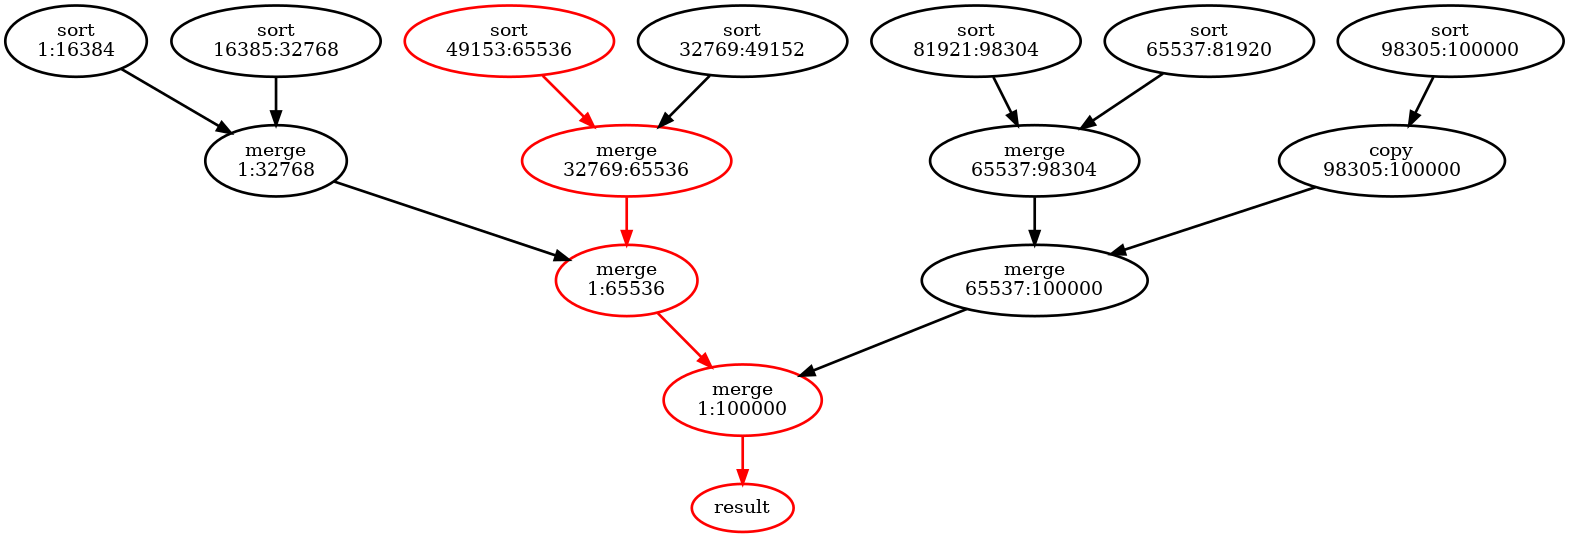

In [7]:
log_info = DataFlowTasks.@log mergesort_dft!(copy(v))

using GraphViz
dag = GraphViz.Graph(log_info)

## Performance

Let's use bigger data to assess the performance of our implementations:

In [8]:
N = 1_000_000
data = rand(N);
buf  = similar(data);

using BenchmarkTools
bench_seq = @benchmark mergesort!(x, $buf) setup=(x=copy(data)) evals=1

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  115.746 ms … 117.895 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     116.009 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   116.372 ms ± 820.681 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  ▁ █ ▁▁   ▁                                          ▁    ▁  
  █▁▁█▁█▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  116 ms           Histogram: frequency by time          118 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [9]:
bench_dft = @benchmark mergesort_dft!(x, $buf) setup=(x=copy(data)) evals=1

BenchmarkTools.Trial: 21 samples with 1 evaluation.
 Range (min … max):  33.464 ms … 53.803 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     41.236 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   41.732 ms ±  4.546 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                     ▃   █       █                             
  ▇▁▁▁▁▁▇▁▁▇▁▁▁▇▇▁▁▁▇█▇▇▇█▁▁▁▁▁▇▁█▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▇ ▁
  33.5 ms         Histogram: frequency by time        53.8 ms <

 Memory estimate: 7.97 MiB, allocs estimate: 4788.

The parallel version does exhibit some speed-up, but not as much as one would
hope for given the number of threads used in the computation:

In [10]:
(;
 nthreads = Threads.nthreads(),
 speedup = time(minimum(bench_seq)) / time(minimum(bench_dft)))

(nthreads = 16, speedup = 3.458780279917308)

To better understand why the speedup may not be as good as expected, we can
inspect the execution trace of the parallel version and visualize it using
`Makie`:

[ Info: Computing    : 0.344023472
[ Info: Inserting    : 0.0005311250000000001
[ Info: Other        : 0.32960714637267857


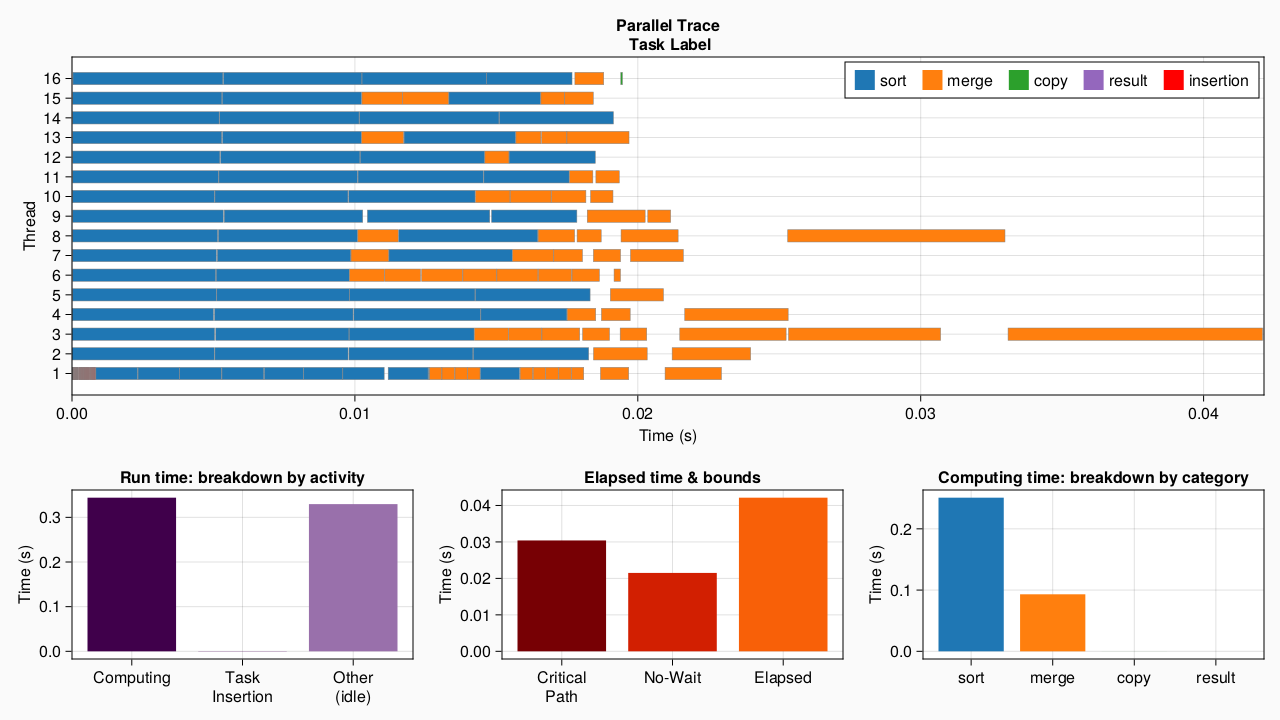

In [11]:
log_info = DataFlowTasks.@log mergesort_dft!(copy(data))
plot(log_info; categories = ["sort", "merge", "copy", "result"])

The parallel profile explains it all: at the beginning of the computation,
sorting the small blocks and merging them involves a large number of small
tasks. There is a lot of expressed parallelism to be taken advantage of at
this stage, and `DataFlowTasks` seems to do a good job. But as the algorithm
advances, fewer and fewer blocks have to be merged, which are larger and
larger... until the last merge of the whole array (which is performed
sequentially) seemingly accounts for as much as 25% of the whole computation
time!

## Parallel merge

In order to express more parallelism in the algorithm, it is therefore
important to perform large merges in parallel. There exist many elaborate
[parallel binary merge
algorithms](https://en.wikipedia.org/wiki/Merge_algorithm); here we describe a
relatively naive one:

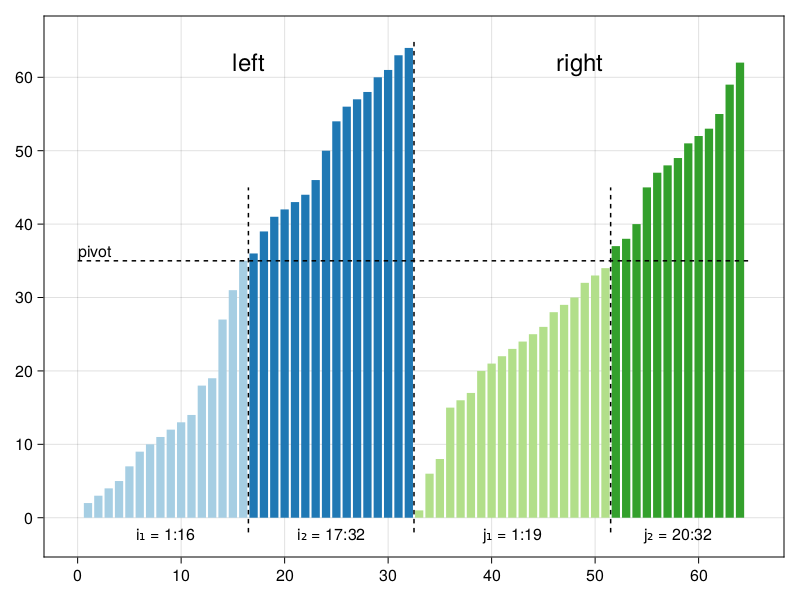

In [12]:
# Assuming we want to sort `v`, and its `left` and `right` halves have already
# been sorted, we merge them into `dest`:
v = randperm(64)
left  = @views v[1:32]; sort!(left)
right = @views v[33:64]; sort!(right)
dest = similar(v)

(I, J, K) = length(left), length(right), length(dest)
@assert I+J == K

# First we find a pivot value, which splits `left` in two halves:
i = 1 + I ÷ 2
pivot = left[i-1]

# Next we split `right` into two parts: indices associated to values lower than
# the pivot, and indices associated to values larger than the pivot. Since the
# data is sorted, an efficient binary search algorithm can be used:
j = searchsortedfirst(right, pivot)

# We now have both `left` and `right` decomposed into two (hopefully nearly
# equal) parts:
(i₁, i₂) = (1:i-1, i:I)  # partition of `left`
(j₁, j₂) = (1:j-1, j:J)  # partition of `right`

display_split(v, i₁, i₂, j₁, j₂)

Between them, the first part of `left` and the first part of `right` contain
all values lower than or equal to `pivot`: they can be merged together in the
first part of the destination array, which will also contain all values lower
than or equal to `pivot`.

The same is true of the second parts of `left` and `right`, which contain all
values larger than `pivot` and can be merged into the second part of the
destination array.

In [13]:
# Find the index which splits `dest` into two parts, according to the number of
# elements in the first parts of `left` and `right`
k = i + j - 1
(k₁, k₂) = (1:k-1, k:K)  # partition of `dest`

# Merge the first parts
@views merge!(dest[k₁], left[i₁], right[j₁])

# Merge the second parts
@views merge!(dest[k₂], left[i₂], right[j₂])

# We now have a fully sorted array
@assert issorted(dest)

The following function automates the splitting of the arrays into `P` parts,
desribed as a vector of `(iₚ, jₚ, kₚ)` tuples:

In [14]:
function split_indices(P, dest, left, right)
    (I, J, K) = length(left), length(right), length(dest)
    @assert I+J == K

    i = ones(Int, P+1)
    j = ones(Int, P+1)
    k = ones(Int, P+1)
    for p in 2:P
        i[p] = 1 + ((p-1)*I) ÷ P
        j[p] = searchsortedfirst(right, left[i[p]-1])
        k[p] = k[p-1] + i[p]-i[p-1] + j[p]-j[p-1]
    end
    i[P+1] = I+1; j[P+1] = J+1; k[P+1] = K+1

    map(1:P) do p
        (i[p]:i[p+1]-1, j[p]:j[p+1]-1, k[p]:k[p+1]-1)
    end
end

# Check that this decomposes `left` and `right` into the same ranges as shown
# in the figure above:
split_indices(2, dest, left, right)

2-element Vector{Tuple{UnitRange{Int64}, UnitRange{Int64}, UnitRange{Int64}}}:
 (1:16, 1:19, 1:35)
 (17:32, 20:32, 36:64)

This can serve as a building block for a parallel merge and new version of the
parallel merge sort:

In [15]:
function parallel_merge_dft!(dest, left, right; label="")
    # Number of parts in which large blocks will be split
    P = min(Threads.nthreads(), ceil(Int, length(dest)/65_536))

    # Simple sequential merge for small cases
    if P <= 1
        @dspawn merge!(@W(dest), @R(left), @R(right)) label="merge\n$label"
        return dest
    end

    # Split the arrays into `P` parts. It is important to use `@dspawn` here so
    # that `split_indices` wait until the previous tasks are finished sorting
    idxs_t = @dspawn split_indices(P, @R(dest), @R(left), @R(right)) label="split\n$label"
    idxs   = fetch(idxs_t)::Vector{NTuple{3, UnitRange{Int}}}

    # Spawn one task per part
    for p in 1:P
        part = 'A' + p -1
        iₚ, jₚ, kₚ = idxs[p]
        left′, right′, dest′ = @views left[iₚ], right[jₚ], dest[kₚ]
        @dspawn merge!(@W(dest′), @R(left′), @R(right′)) label="merge $part\n$label"
    end
    return dest
end

parallel_merge_dft! (generic function with 1 method)

With this parallel merge version, we can now re-write the mergesort
algorithm to spawn parallel merge tasks:

In [16]:
function parallel_mergesort_dft!(v, buf=similar(v); bs=16384)
    N = length(v)

    for i₀ in 1:bs:N
        i₁ = min(i₀+bs-1, N)
        @dspawn mergesort!(@RW(view(v, i₀:i₁))) label="sort\n$i₀:$i₁"
    end

    (from, to) = (v, buf)

    while bs < N
        i₀ = 1
        while i₀ < N
            i₁ = i₀+bs; i₁>N && break
            i₂ = min(i₀+2bs-1, N)
            let
                left  = @view from[i₀:i₁-1]
                right = @view from[i₁:i₂]
                dest  = @view to[i₀:i₂]
                parallel_merge_dft!(dest, left, right, label="$i₀:$i₂")
            end
            i₀ = i₂+1
        end
        if i₀ <= N
            let
                src  = @view from[i₀:N]
                dest = @view to[i₀:N]
                @dspawn @W(dest) .= @R(src) label="copy\n$i₀:$N"
            end
        end

        bs *= 2
        (from, to) = (to, from)
    end

    final_task = @dspawn @R(from) label="result"
    fetch(final_task)
    v === from || copy!(v, from)
    v
end

parallel_mergesort_dft! (generic function with 2 methods)

Let us check that this new version still works as expected:

In [17]:
N = 100_000
v = rand(N)
@assert issorted(parallel_mergesort_dft!(copy(v)))

The task graph is now a bit more complicated. Here we see for example that the
last level of merge has been split into 2 parts (labelled "merge A" and "merge B"):

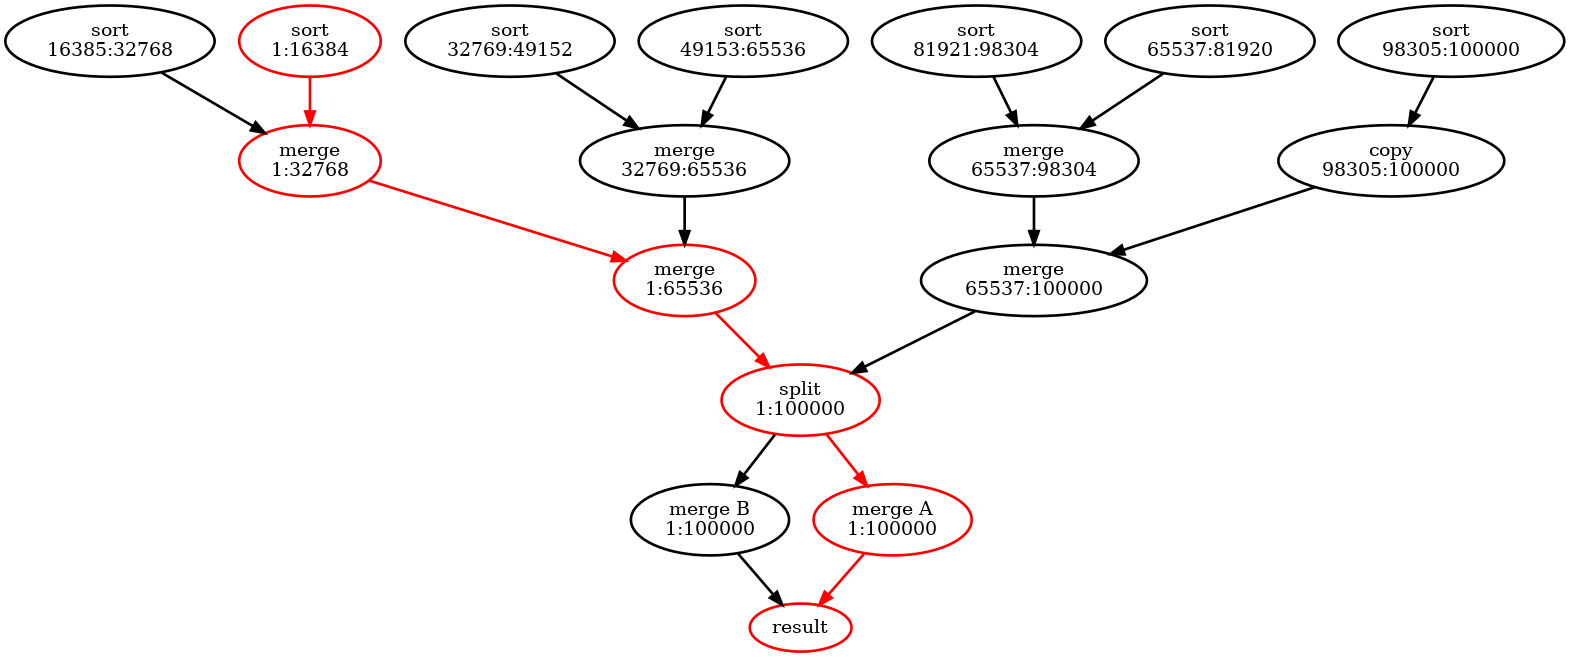

In [18]:
# Temporarily stop the DAG cleaner from dynamically removing nodes from the task
# graph in order to obtain the full "static graph".
DataFlowTasks.stop_dag_cleaner()
log_info = DataFlowTasks.@log parallel_mergesort_dft!(copy(v))
DataFlowTasks.start_dag_cleaner()

using GraphViz
dag = GraphViz.Graph(log_info)

Since it expresses more parallelism, this new version performs better:

In [19]:
buf = similar(data)
bench_dft_tiled = @benchmark parallel_mergesort_dft!(x, $buf) setup = (x = copy(data)) evals = 1

BenchmarkTools.Trial: 38 samples with 1 evaluation.
 Range (min … max):  16.438 ms … 25.806 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.481 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   18.964 ms ±  2.145 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▂▅    █    ▂                                          
  ▅▁▅▅█▁▅███▅▅██▅▁▅▁█▁▅▅▁▅▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▅▅ ▁
  16.4 ms         Histogram: frequency by time        25.8 ms <

 Memory estimate: 8.12 MiB, allocs estimate: 6518.

In [20]:
(;
    nthreads = Threads.nthreads(),
    speedup = time(minimum(bench_seq)) / time(minimum(bench_dft_tiled)),
)

(nthreads = 16, speedup = 7.041500191967445)

The profile plot also shows how merge tasks remain parallel until the very end:

[ Info: Computing    : 0.3235305690000001
[ Info: Inserting    : 0.0005633010000000001
[ Info: Other        : 0.036843058540468224


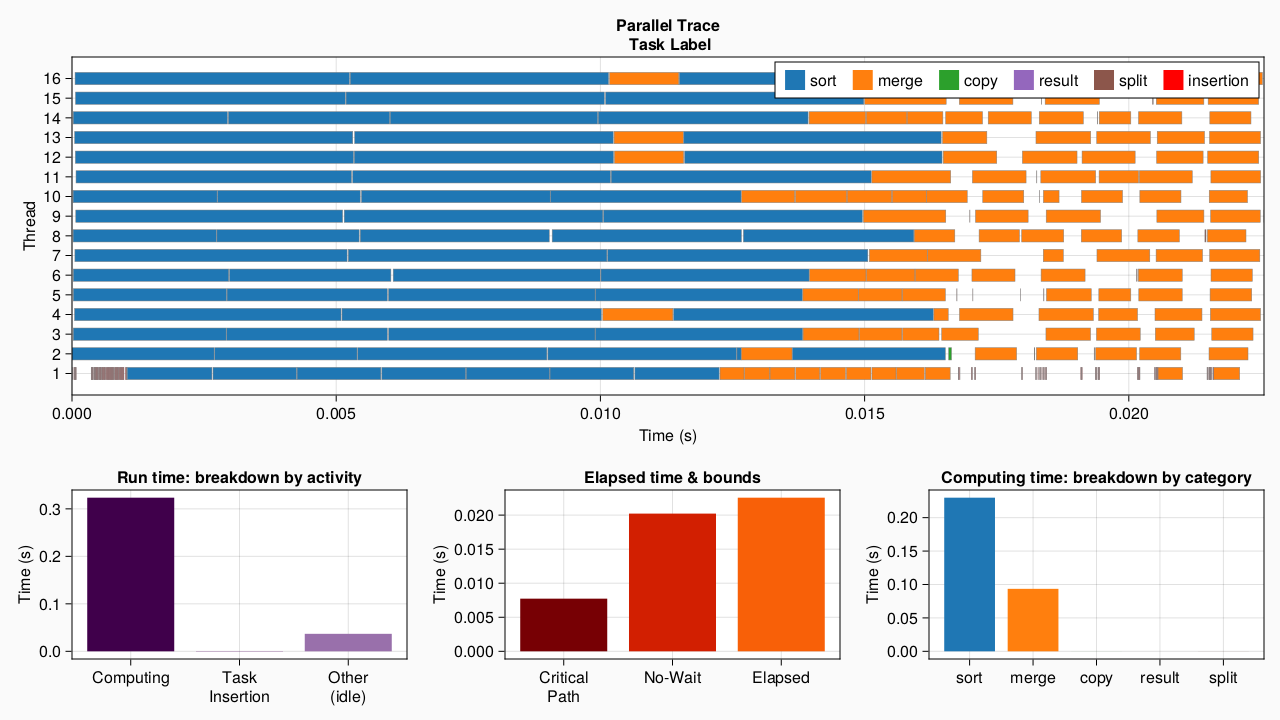

In [21]:
log_info = DataFlowTasks.@log parallel_mergesort_dft!(copy(data))
plot(log_info, categories=["sort", "merge", "copy", "result", "split"])

Here, one extra performance limiting factor is the additional work performed
by the parallel merge algorithm (*e.g.* finding pivots). Compare for example
the sequential elapsed time:

In [22]:
bench_seq

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  115.746 ms … 117.895 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     116.009 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   116.372 ms ± 820.681 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁  ▁ █ ▁▁   ▁                                          ▁    ▁  
  █▁▁█▁█▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█ ▁
  116 ms           Histogram: frequency by time          118 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

to the cumulated run time of the tasks (shown as "Computing" in the `log_info`
description):

In [23]:
DataFlowTasks.describe(log_info)

• Elapsed time           : 0.023
  ├─ Critical Path       : 0.008
  ╰─ No-Wait             : 0.020

• Run time               : 0.361
  ├─ Computing           :   0.324
  │  ╰─ unlabeled        :     0.324
  ├─ Task Insertion      :   0.001
  ╰─ Other (idle)        :   0.037


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*